### <div class="label label-info">CLAUDIO SCALZO</div>
# ASI Challenge Exercise
### Naive Bayes Classification and Bayesian Linear Regression on the <tt>Fashion-MNIST</tt> and <tt>CIFAR-10</tt> datasets

In [1]:
### LIBRARIES IMPORT

# Data structures
import numpy as np
import pandas as pd
from numpy.linalg import inv

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities
import math as math
from time import time, sleep
import pickle
import itertools

# Distrubutions
from scipy.stats import skew, probplot, multivariate_normal

# Error
from sklearn.metrics import explained_variance_score, mean_squared_error, confusion_matrix

<div class='alert alert-info'>
<div class='label label-info'>INSTRUCTIONS TO RUN THE NOTEBOOK</div>
<br>
To be able to run the notebook the only thing to ensure is that the datasets are in the correct directories. The following structure is the correct one:
<code>
- asi_challenge_claudio_scalzo.ipynb
- datasets/
    - Fashion-MNIST/
        - fashion-mnist_train.csv
        - fashion-mnist_test.csv
    - CIFAR-10/
        - data_batch_1
        - data_batch_2
        - data_batch_3
        - data_batch_4
        - data_batch_5
        - test_batch
</code>
<br>
<div class='label label-info'>COLORS</div>
<br>
For the sake of readability, the notebook will follow a color convention:
<br>
<ul>
    <li>All the cells related to the <tt>Fashion-MNIST</tt> dataset will be in green and labeled with: <div class="label label-success">FASHION-MNIST</div></li>
    <li>All the cells related to the <tt>CIFAR-10</tt> dataset will be in yellow and labeled with: <div class="label label-warning">CIFAR-10</div></li>
    <li>All the blue cells are generic comments and the answers to the exercise questions are marked with: <div class="label label-danger">ANSWER</div></li>
</ul>
<br>
<div class='label label-info'>SECTIONS</div>
<br>
The sections numbering will follow exactly the one provided in the requirements PDF.
</div>

# 1. Datasets loading

<div class='alert alert-info'>
The first step consists in the datasets import. This process will be split in two parts, one for the <tt>Fashion-MNIST</tt> dataset and another one for the <tt>CIFAR-10</tt> dataset. While in the first case it will be very easy (being the dataset saved in <b>csv</b> files), in the seconds case the process will be longer, because the CIFAR datasets are saved in <b>binary</b> files.
</div>

### <div class="label label-success">FASHION-MNIST</div>

<div class='alert alert-success'>
Let's define the datasets location and load them in two Pandas DataFrame: <tt>mnistTrain</tt> and <tt>mnistTest</tt>.
</div>

In [2]:
# DIRECTORY AND CONSTANTS DEFINITION
mnistPath = "./datasets/Fashion-MNIST/"
height = 28
width = 28

# FILEPATHS DEFINITION
mnistTrainFile = mnistPath + "fashion-mnist_train.csv"
mnistTestFile = mnistPath + "fashion-mnist_test.csv"

# LOAD THE MNIST AND CIFAR TRAINSET AND DATASET
mnistTrain = pd.read_csv(mnistTrainFile)
mnistTest = pd.read_csv(mnistTestFile)

<div class='alert alert-success'>
Now we can show some example of the loaded data:
</div>

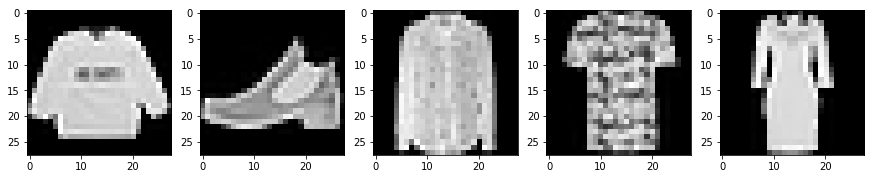

In [3]:
# SHOW SOME SAMPLES
plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    image = mnistTrain.drop(columns=["label"]).loc[i].values.reshape((height, width))
    plt.imshow(image, cmap="gray")
plt.show()

### <div class="label label-warning">CIFAR-10</div>

<div class='alert alert-warning'>
First of all, we have to declare the path of the <tt>CIFAR-10</tt> datasets and some useful values:
</div>

In [4]:
# DIRECTORY AND CONSTANTS DEFINITION
cifarPath = "./datasets/CIFAR-10/"
trainfiles = 5
height = 32
width = 32
channels = 3
pixels = height * width * channels

<div class='alert alert-warning'>
Now, let's define a function to load a single binary file which contains a certain number of images:
</div>

In [5]:
# FUNCTION TO LOAD A SINGLE TRAINFILE
def loadImages(filename, height, width, channels):
    
    # Load binary file
    file = open(filename, "rb")
    
    # Unpickle
    data = pickle.load(file, encoding="bytes")
    
    # Get raw images and raw classes
    rawImages = data[b'data']
    rawClasses = data[b'labels']
    
    return np.array(rawImages, dtype=int), np.array(rawClasses, dtype=int)

<div class='alert alert-warning'>
Now it's time to use the previous function to load all the five <b>trainsets</b> in our directory: they will be merged in a unique Pandas DataFrame named <tt>cifarTrain</tt>.
</div>

In [6]:
# ALLOCATE AN EMPTY ARRAY (width of number of pixels + one for the class label)
images = np.empty(shape=(0, pixels + 1), dtype=int)

# LOAD ALL THE TRAINFILES
for i in range(trainfiles):
    
    # Load the images and classes for the "i"th trainfile
    newImages, newClasses = loadImages(filename = cifarPath + "data_batch_" + str(i + 1),
                                       height = height,
                                       width = width,
                                       channels = channels)
    
    # Create the new batch (concatenating images and classes)
    newBatch = np.concatenate((np.asmatrix(newClasses).T, newImages), axis=1)
    
    # Concatenate the new batch with the previous ones
    images = np.concatenate((images, newBatch), axis=0)

# CREATE THE TRAIN DATAFRAME
attributes = [("pixel" + str(i) + "_" + str(c)) for c in ["r", "g", "b"] for i in range(height * width)]
cifarTrain = pd.DataFrame(images, columns = ["label"] + attributes)

<div class='alert alert-warning'>
The <tt>cifarTrain</tt> has been imported, now let's do the same for the file containing the <b>testset</b>: also in this case, it will be saved in a dataframe, <tt>cifarTest</tt>.
</div>

In [7]:
# LOAD THE IMAGES AND CLASSES
newImages, newClasses = loadImages(filename = cifarPath + "test_batch",
                                   height = height,
                                   width = width,
                                   channels = channels)

# CREATE THE IMAGES ARRAY (concatenating images and classes)
images = np.concatenate((np.asmatrix(newClasses).T, newImages), axis=1)

# CREATE THE TEST DATAFRAME
attributes = [("pixel" + str(i) + "_" + str(c)) for i in range(height * width) for c in ["r", "g", "b"]]
cifarTest = pd.DataFrame(images, columns = ["label"] + attributes)

<div class='alert alert-warning'>
Now we can show some example of the loaded data:
</div>

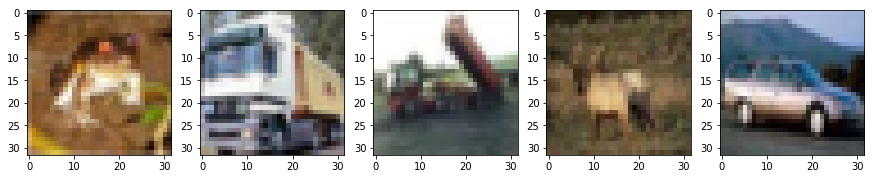

In [8]:
# SHOW SOME SAMPLES
plt.figure(figsize=(15,10))
for i in range(0,5):
    plt.subplot(1,5,i+1)
    imageR = cifarTrain.iloc[i,1:1025].values.reshape((height,width))
    imageG = cifarTrain.iloc[i,1025:2049].values.reshape((height,width))
    imageB = cifarTrain.iloc[i,2049:3073].values.reshape((height,width))
    image = np.dstack((imageR, imageG, imageB))
    plt.imshow(image)
plt.show()

<div class='alert alert-info'>
Everything is loaded! We can start analyzing our data.
</div>

# 2. Descriptive statistics

### 2.1 Data description

<div class='alert alert-info'>
The first step is to investigate data. It is a fundamental section, where we will learn about our data. Initially we show and plot really simple statistics: they are useful to introduce us, to understand what we are dealing with.
</div>

### <div class="label label-success">FASHION-MNIST</div>

In [9]:
# PRINT TO DESCRIBE THE TRAIN
print("Number of rows:", mnistTrain.shape[0])
print("Attributes:", mnistTrain.drop(columns=['label']).shape[1], "(without considering the label)")
display(mnistTrain.head(5))

Number of rows: 60000
Attributes: 784 (without considering the label)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class='alert alert-success'>
The number of rows is <b>60000</b>, while the number of columns is <b>785</b> (784 attributes + 1 label). But what does they mean?<br>
<br>
<list>
    <li>Each <b>row</b> represents a picture.</li>
    <li>Each <b>column</b> represents a pixel.</li>
    <li>So, the <b>value</b> of a row <i>"r"</i> in a given column <i>"c"</i> represents the brightness (from 0 to 255) of a given pixel <i>"c"</i> in a given picture <i>"r"</i>.</li>
</list>
<br>
If training on a big (where big refers to the number of pictures) dataset represent an advantage, a big dimensionality like this (784 attributes) can represent an issue for the predictive model, generally known as "curse of dimensionality" (<a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality">source</a>).
</div>

In [10]:
# PRINT TO DESCRIBE THE TEST
print("Number of rows:", mnistTest.shape[0])
print("Attributes:", mnistTest.drop(columns=['label']).shape[1], "(without considering the label)")
display(mnistTest.head(5))

Number of rows: 10000
Attributes: 784 (without considering the label)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class='alert alert-success'>
In the testset we find the same situation but with a smaller row dimension: <b>10000</b>. The number of columns is, of course, the same: <b>785</b> (784 attributes + 1 label).
</div>

### <div class="label label-warning">CIFAR-10</div>

In [11]:
# PRINT TO DESCRIBE THE TRAIN
print("Number of rows:", cifarTrain.shape[0])
print("Attributes:", cifarTrain.drop(columns=['label']).shape[1], "(without considering the label)")
display(cifarTrain.head(5))

Number of rows: 50000
Attributes: 3072 (without considering the label)


,label,pixel0_r,pixel1_r,pixel2_r,pixel3_r,pixel4_r,pixel5_r,pixel6_r,pixel7_r,pixel8_r,...,pixel1014_b,pixel1015_b,pixel1016_b,pixel1017_b,pixel1018_b,pixel1019_b,pixel1020_b,pixel1021_b,pixel1022_b,pixel1023_b
0,6,59,43,50,68,98,119,139,145,149,...,59,58,65,59,46,57,104,140,84,72
1,9,154,126,105,102,125,155,172,180,142,...,22,42,67,101,122,133,136,139,142,144
2,9,255,253,253,253,253,253,253,253,253,...,78,83,80,69,66,72,79,83,83,84
3,4,28,37,38,42,44,40,40,24,32,...,53,39,59,42,44,48,38,28,37,46
4,1,170,168,177,183,181,177,181,184,189,...,92,88,85,82,83,79,78,82,78,80


<div class='alert alert-warning'>
The number of rows is <b>50000</b>, because we merged 5 files of 10000 rows (images) each. The number of columns is instead <b>3073</b> (3072 attributes + the label): why this number?<br>
Because each picture was a 32x32 pixels, with 3 channels (RGB): so each picture has 3072 pixels.
</div>

In [12]:
# PRINT TO DESCRIBE THE TEST
print("Number of rows:", cifarTest.shape[0])
print("Attributes:", cifarTest.drop(columns=['label']).shape[1], "(without considering the label)")
display(cifarTest.head(5))

Number of rows: 10000
Attributes: 3072 (without considering the label)


,label,pixel0_r,pixel0_g,pixel0_b,pixel1_r,pixel1_g,pixel1_b,pixel2_r,pixel2_g,pixel2_b,...,pixel1020_b,pixel1021_r,pixel1021_g,pixel1021_b,pixel1022_r,pixel1022_g,pixel1022_b,pixel1023_r,pixel1023_g,pixel1023_b
0,3,158,159,165,166,160,156,162,159,158,...,130,123,145,167,182,175,145,124,129,110
1,8,235,231,232,232,232,232,232,232,232,...,108,117,123,133,141,153,163,178,191,199
2,8,158,158,139,132,166,182,187,193,199,...,45,46,44,44,43,52,37,8,3,7
3,0,155,167,176,190,177,166,168,166,170,...,52,55,70,103,105,72,53,50,52,50
4,6,65,70,48,30,23,40,44,45,45,...,102,127,156,139,131,130,147,136,146,117


<div class='alert alert-warning'>
The number of rows in the testset is smaller: <b>10000</b>.
</div>

### 2.2 Data distribution analysis

<div class='alert alert-info'>
Now is time to analyze the distribution of our data. In this section I'm going to analyze the distribution of <b>both</b> the trainset and the testset, so I'll create the <tt>all</tt> variables.
</div>

In [13]:
# CREATE THE 'ALL' DATAFRAMES
mnistAll = pd.concat((mnistTrain, mnistTest)).reset_index(drop=True)
cifarAll = pd.concat((cifarTrain, cifarTest)).reset_index(drop=True)

### <div class="label label-success">FASHION-MNIST</div> <div class="label label-warning">CIFAR-10</div>

In [14]:
# TAKE DISTRIBUTION
mnistDistribution = mnistAll["label"].value_counts()
cifarDistribution = cifarAll["label"].value_counts()

# TAKE NUMBERS AND FREQUENCIES
mnistNumbers = np.array(mnistDistribution.index)
mnistFrequencies = np.array(mnistDistribution.values)
cifarNumbers = np.array(cifarDistribution.index)
cifarFrequencies = np.array(cifarDistribution.values)

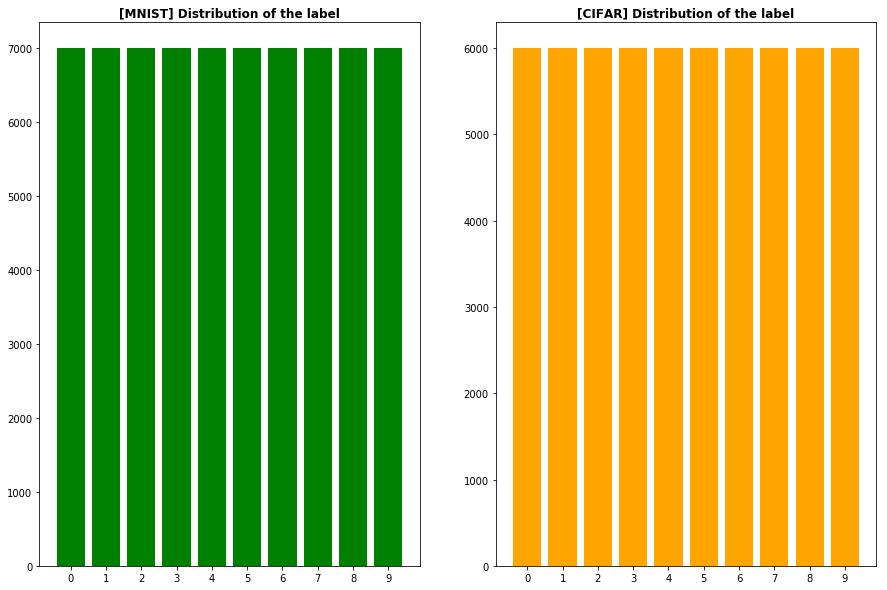

In [15]:
# PLOT THE DISTRIBUTION OF THE TARGET VARIABLE
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.bar(mnistNumbers, mnistFrequencies, align="center", color="green")
plt.xticks([i for i in range(np.min(mnistNumbers),np.max(mnistNumbers)+1)])
plt.title("[MNIST] Distribution of the label", weight="semibold");

plt.subplot(1,2,2)
plt.bar(cifarNumbers, cifarFrequencies, align="center", color="orange")
plt.xticks([i for i in range(np.min(cifarNumbers),np.max(cifarNumbers)+1)])
plt.title("[CIFAR] Distribution of the label", weight="semibold");

plt.show()

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<i><b>Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.</b></i><br>
<br>
<div class='label label-danger'>ANSWER</div><br>
The distribution is <b>uniform</b>...<br>
The dimensionality is very high...<br>
This could be a problem for our Naive Bayes implementation, which expects a Gaussian distribution to work well. Let's see what happens.
</div>

<div class='alert alert-info'>
Before starting the new section, let's define the function to graphically plot the confusion matrix. This function will be useful to show the classifier and the regressor performance in the two datasets.
</div>

In [16]:
def plotConfusionMatrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Greens):

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 3. Classification

### 3.a Naive Bayes Classifier

<div class='alert alert-info'>
Naive Bayes Classifier explanation here...
</div>

In [17]:
class NaiveBayesClassifier:
    
    # ----- PRIVATE METHODS ------------------------------------------------- #
    # MEANS AND VARIANCES FOR THE LIKELIHOOD: P(X|C)
    def _computeMeansCov(self):
        
        # Compute means and variances
        # -> For example:
        #    <means> |  attr0 | attr1 | ...    #  <vars> |  attr0 | attr1 | ...
        #    --------------------------        # --------------------------    
        #    class0  |   12   |   3   | ...    # class0  |   0.2  |  0.03 | ...
        #    class1  |   8    |   0   | ...    # class1  |  0.07  |  0.1  | ...
        #      ...   |  ...   |  ...  | ...    #   ...   |  ...   |  ...  | ...
        self.means = self.train.groupby("label").mean()
        self.cov = self.train.groupby("label").var()
    
    
    # PRIORS: P(C)
    def _computePriors(self):
        
        # Set a probability for each class: a dictionary of all P(Ci)
        # -> For example: {class0: 0.01, class1: 0.27, ...}
        self.priors = {k: v / self.nTrain for k, v in self.frequencies.items()}
    
    
    # LIKELIHOOD: P(X|C)
    def _logLikelihood(self, data, c):
        
        # Means and variances for class "c"
        meansC = np.array(self.means.loc[c])
        covC = np.array(self.means.loc[c])
        
        # Use the logarithmic pdf of the Multivariate Gaussian
        return multivariate_normal.logpdf(data, meansC, covC + 1e-3)
    # ----------------------------------------------------------------------- # 
    
    
    # ----- PUBLIC METHODS -------------------------------------------------- #
    # TRAIN - LIKELIHOOD and PRIOR
    def fit(self, train):
        
        # Trainset
        self.train = train
        self.nTrain, self.kTrain = train.shape
        
        # Compute the distribution of the label
        self.frequencies = train["label"].value_counts().to_dict()
        
        # Classes
        self.classes = list(sorted(self.frequencies.keys()))
        self.numC = len(self.classes)
        
        # Compute priors and likelihoods
        self._computePriors()
        self._computeMeansCov()
        
        return self.classes
    
    
    # TEST - POSTERIOR: P(C|X)
    def predict(self, test):
        
        # Testset
        self.nTest, self.kTest = test.shape
        
        # Init posterior array
        # -> For example:
        #     <post>  |  class0 | class1 | ...
        #    -----------------------------
        #    sample0  |   0.1   |  0.4   | ...
        #    sample1  |   0.18  |  0.35  | ...
        #      ...    |   ...   |  ...   | ...
        posterior = np.zeros((self.nTest, self.numC))

        # For each class
        for c in self.classes:

            # Compute posterior for class "c"
            # -> posterior = likelihood * prior
            #    or
            # -> log(posterior) = log(likelihood) + log(prior)
            posterior[:,c] = self._logLikelihood(test, c) + np.log(self.priors[c])

        # Select the class with max probability for each sample
        predictions = np.argmax(posterior, axis=1)
        
        return predictions
    
    
    # VALIDATE PREDICTION
    def validate(self, pred, correct):
        
        # Accuracy, error, confusion matrix
        acc = np.mean(pred == correct)
        err = np.mean(pred != correct)
        cm = confusion_matrix(correct, pred)
        
        # Return the average number of equal and different classes
        return acc, err, cm
    # ----------------------------------------------------------------------- #

In [18]:
# CLASSIFY FUNCTION
def classify(train, test, correct, color):
    
    # NAIVE BAYES CLASSIFIER
    nbc = NaiveBayesClassifier()

    # TRAIN
    startTime = time()
    classes = nbc.fit(train)
    endTime = time()
    print("Train time: %.3f seconds" % (endTime-startTime))

    # TEST
    startTime = time()
    pred = nbc.predict(test)
    endTime = time()
    print("Test time: %.3f seconds" % (endTime-startTime))

    # ACCURACY AND ERROR
    accuracy, error, cm = nbc.validate(pred, correct)
    print("Accuracy: %.2f%%   |   Error: %.2f%%" % (accuracy * 100, error * 100))
    plotConfusionMatrix(cm, classes, title="[Classification] Confusion Matrix", cmap = color)

### <div class="label label-success">FASHION-MNIST</div>

<div class='alert alert-success'>
Let's start the classification for the <tt>Fashion-MNIST</tt> dataset:
</div>

Train time: 1.804 seconds
Test time: 4.050 seconds
Accuracy: 63.78%   |   Error: 36.22%


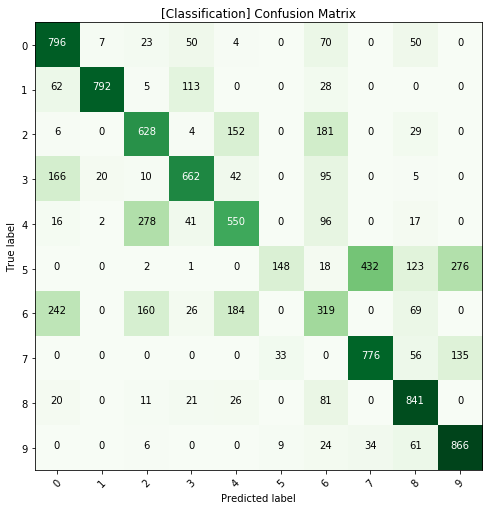

In [19]:
# CLASSIFY
classify(train = mnistTrain,
         test = mnistTest.drop(columns=['label']),
         correct = mnistTest['label'],
         color = "Greens")

### <div class="label label-warning">CIFAR-10</div>

<div class='alert alert-warning'>
Now it's time for the <tt>CIFAR-10</tt> classification:
</div>

Train time: 9.483 seconds
Test time: 79.862 seconds
Accuracy: 26.04%   |   Error: 73.96%


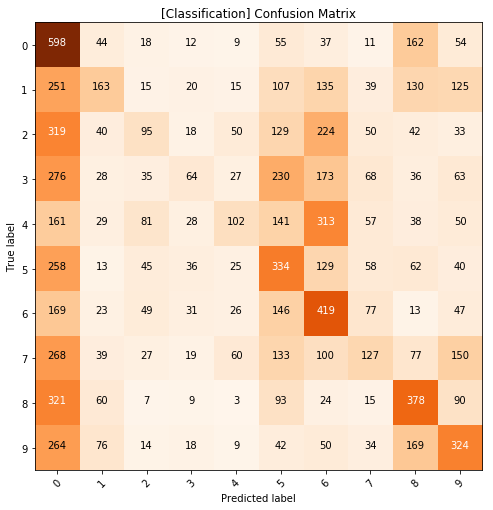

In [20]:
# CLASSIFY
classify(train = cifarTrain,
         test = cifarTest.drop(columns=['label']),
         correct = cifarTest['label'],
         color = "Oranges")

# 4. Linear Regression

<div class='alert alert-info'>
Bayesian Linear Regression explanation here...
</div>

In [21]:
class BayesianLinearRegression:
    
    # ----- PRIVATE METHODS ------------------------------------------------- #
    # CREATE THE MATRIX FOR THE MATRICIAL-FORM REGRESSION
    # -> The shape will be:
    #    1   x1^1   x1^2   ...
    #    1   x2^1   x2^2   ...
    #    1   x3^2   x3^2   ...
    #   ...   ...    ...   ...
    def _matricize(self, x, k):
        
        # ALLOCATE MATRIX
        X = np.ones(shape=(x.shape[0], x.shape[1]), dtype=int)
        
        # STACK COLUMNS
        for i in range(k):
            X = np.hstack((X, np.power(x, i+1))) 
            
        return X
    
    
    # COMPUTE THE WEIGHTS ARRAY
    def _weights(self, X, t):
        
        noise = np.diag(np.random.random(X.shape[1]))
        
        return inv(X.T.dot(X) + noise).dot(X.T).dot(t)
    
    
    # RETURN THE VARIANCE
    def _variance(self, X, w, t):
        
        return (t - X.dot(w.T)).T.dot(t - X.dot(w.T)) / X.shape[0]
    
    
    # RETURN THE PREDICTED t
    def _target(self, X_new, w):
        
        return X_new.dot(w.T)
    
    
    # RETURN THE PREDICTIVE VARIANCE
    def _predictiveVar(self, X_new, X, var):
        
        noise = np.diag(np.random.random(X.shape[1]))
        
        # ("+" instead of "*" for numerical reasons)
        return var + np.diag(X_new.dot(inv(X.T.dot(X) + noise)).dot(X_new.T))
    # ----------------------------------------------------------------------- #
    
    
    # ----- PUBLIC METHODS -------------------------------------------------- #
    # TRAIN
    def fit(self, train, k):
        
        # Split train in x and t
        self.t = train["label"]
        self.x = train.drop(columns=["label"])
        
        # Compute X, w and t
        self.X = self._matricize(self.x, k)
        self.w = self._weights(self.X, self.t)
        self.var = self._variance(self.X, self.w, self.t)
        
        return sorted(self.t.unique())
    
    
    # TEST
    def predict(self, test, k):
        
        # Compute the matrix for the test set
        X_new = self._matricize(test, k)
        
        # Predict the new target for the test set
        t_new = self._target(X_new, self.w)
        
        # Discretize predictions
        rounder = np.vectorize(lambda label: round(label))
        highLimiter = np.vectorize(lambda label: 9 if label > 9 else label)
        lowLimiter = np.vectorize(lambda label: 0 if label < 0 else label)
        t_new = np.array(lowLimiter(highLimiter(rounder(t_new))), dtype=int)
        
        # Compute the predictive variance
        var_new = self._predictiveVar(X_new, self.X, self.var)
        
        return t_new, var_new
        
    
    # VALIDATION
    def validate(self, pred, correct):
        
        # Accuracy, error, confusion matrix
        acc = np.mean(pred == correct)
        err = np.mean(pred != correct)
        cm = confusion_matrix(correct, pred)
        
        # Return the average number of equal and different classes
        return acc, err, cm
    # ----------------------------------------------------------------------- #

In [22]:
def regress(train, test, correct, k, color):
    
    # BAYESIAN LINEAR REGRESSION
    blr = BayesianLinearRegression()

    # TRAIN
    startTime = time()
    classes = blr.fit(train, k)
    endTime = time()
    print("Train time: %.3f seconds" % (endTime-startTime))

    # TEST
    startTime = time()
    pred, var = blr.predict(test, k)
    endTime = time()
    print("Test time: %.3f seconds" % (endTime-startTime))

    # ACCURACY
    accuracy, error, cm = blr.validate(pred, correct)
    print("Accuracy: %.2f%%   |   Error: %.2f%%" % (accuracy * 100, error * 100))
    plotConfusionMatrix(cm, classes, title="[Regression] Confusion Matrix", cmap = color)

### <div class="label label-success">FASHION-MNIST</div>

Train time: 5.068 seconds
Test time: 4.871 seconds
Accuracy: 18.56%   |   Error: 81.44%


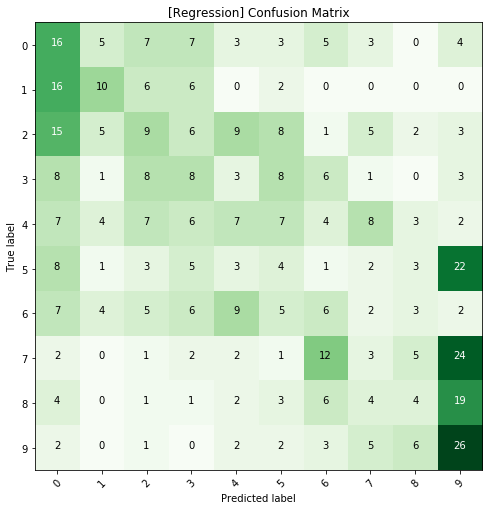

In [23]:
# REGRESS
regress(train = mnistTrain.loc[0:500],
        test = mnistTest.drop(columns=['label']).loc[0:500],
        correct = mnistTest['label'].loc[0:500],
        k = 1,
        color = "Greens")

### <div class="label label-warning">CIFAR-10</div>

In [ ]:
# REGRESS
regress(train = cifarTrain.loc[0:500],
        test = cifarTest.drop(columns=['label']).loc[0:500],
        correct = cifarTest['label'].loc[0:500],
        k = 1,
        color = "Oranges")

Train time: 335.903 seconds
